# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
plt.style.use('dark_background')
print("Setup Complete")

Setup Complete


# Importing Dataset

In [2]:
machine_data = pd.read_csv("../input/machine-failure-predictions/machine failure.csv",index_col="UDI")
machine_data1 = pd.read_csv("../input/playground-series-s3e17/train.csv",index_col="id")
machine_data = machine_data.append(machine_data1)
machine_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Data Cleaning

In [3]:
from sklearn.preprocessing import LabelEncoder


machine_data.drop(["Product ID"],axis=1,inplace=True)
machine_data.columns = ['Type', 'Air_Temp_K', 'Process_Temp_K', 'Rot_Speed', 'Torque',
       'Tool_Wear', 'Machine_Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
catDTypeCols = ['Type']

encoder = LabelEncoder()

machine_data["Type"] = encoder.fit_transform(machine_data["Type"])

machine_data.head()

,Type,Air_Temp_K,Process_Temp_K,Rot_Speed,Torque,Tool_Wear,Machine_Failure,TWF,HDF,PWF,OSF,RNF
1,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Feature Engineering

In [4]:
machine_data["Temp_Diff"] = machine_data["Process_Temp_K"]-machine_data["Air_Temp_K"]
machine_data["Air_Temp_C"] = machine_data["Air_Temp_K"]-273
machine_data["Process_Temp_C"] = machine_data["Process_Temp_K"]-273
machine_data["Power"] = machine_data["Torque"]*machine_data["Rot_Speed"]

# EDA

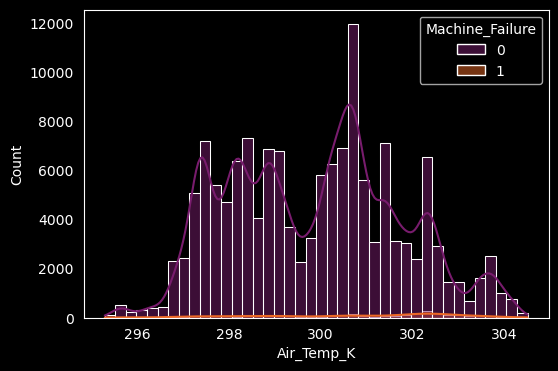

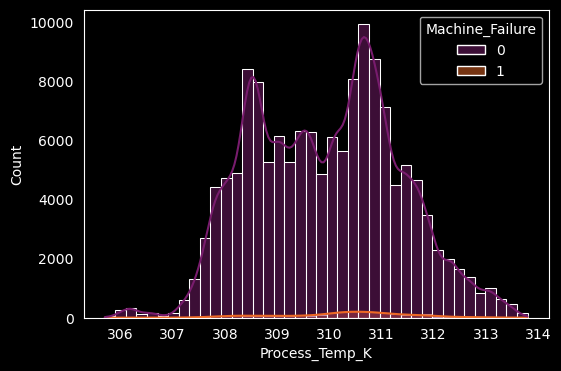

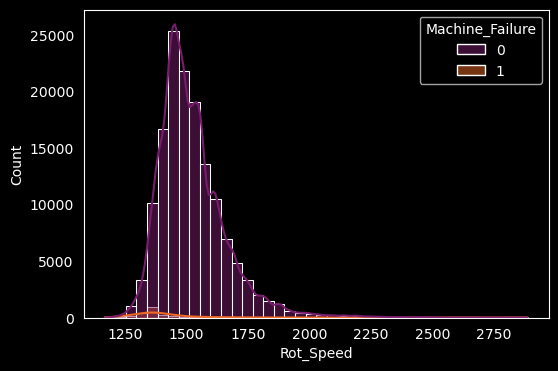

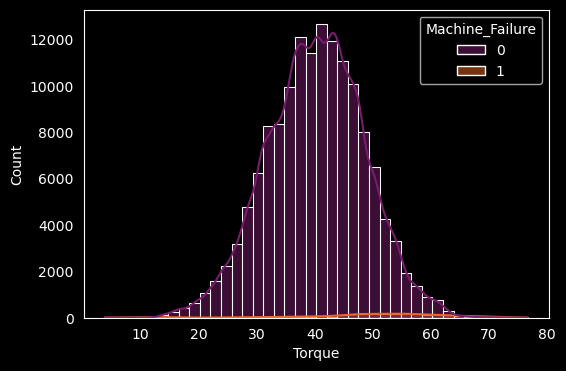

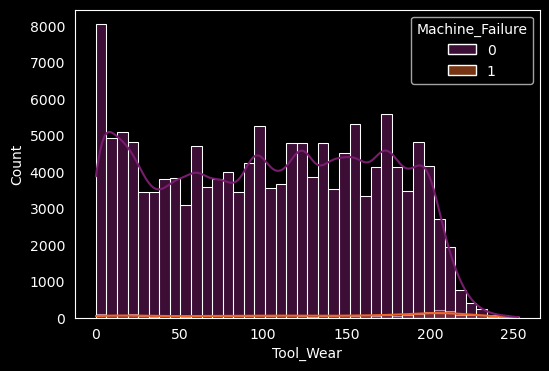

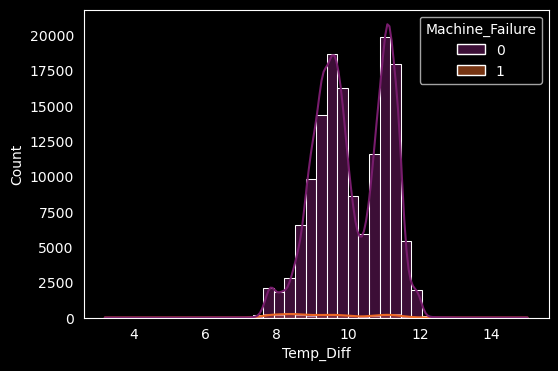

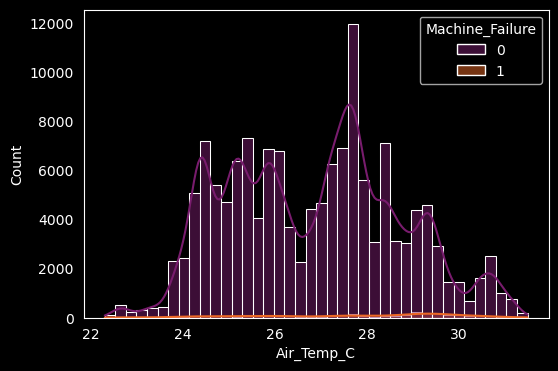

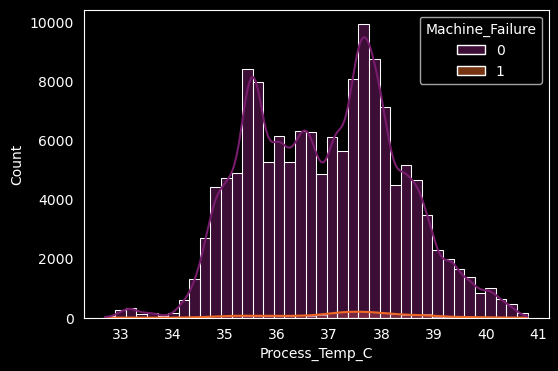

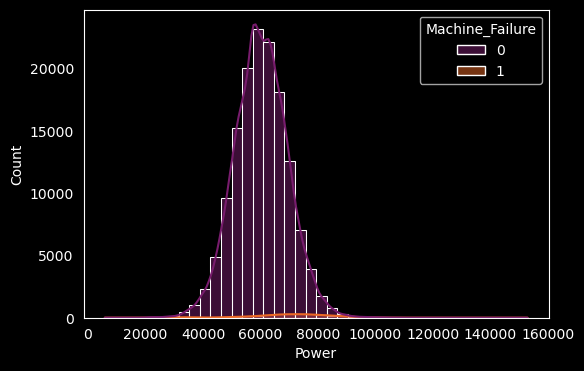

In [5]:
plotCols = [i for i in machine_data.columns if len(machine_data[i].unique())>3]

for i in plotCols:
    plt.figure(figsize=(6,4))
    sns.histplot(machine_data,x =i,hue="Machine_Failure",bins=40,kde=True,palette="inferno")
    plt.show();

# Training Model

### **XGB Parameters Defaults**

---
-  booster = {*gbtree*, gblinear, dart}
-  verbosity = {0(Silent), 1(Warnings) ,2(Info) ,3(Debug)} 
-  max_depth = 3
-  learning_rate = 0.1
-  n_estimators = 100
-  gamma = 0
-  min_child_weight = 1
-  max_delta_step = 0
-  subsample = 1
-  sampling_method = {*uniform*, gradient_based (only supported in tree_method=gpu_hist)}
-  colsample_bytree = 1
-  colsample_bylevel = 1
-  colsample_bynode = 1
-  reg_alpha = 0 (L1 regularization) 
-  reg_lambda = 1 (L2 regularization) 
-  max_leaves = 0 (means no limit)
-  max_bin = 256
-  predictor = {*auto*, cpu_predictor, gpu_predictor (for tree_method=gpu_hist)}
-  tree_method = {*auto*, approx, hist, gpu_hist}
-  grow_policy = {*depthwise*, lossguide} 
-  eval_metric = {rmse, rmsle,mae, mape, mphe, logloss, error, error@t, merror, mlogloss, auc, aucpr, ndcg,poisson-nloglik, gamma-nloglik, cox-nloglik}
-  n_jobs=1
-  nthread=None
-  scale_pos_weight=1
-  base_score=0.5
-  random_state=0
-  silent = True
-  seed=None
-  missing=None

-  objective { 
 -  *reg:squarederror:* regression with squared loss.
 -  reg:squaredlogerror: regression with squared log loss. All input labels are required to be greater than -1.
 -  reg:logistic: logistic regression.
 -  reg:pseudohubererror: regression with Pseudo Huber loss, a twice differentiable alternative to absolute loss.
 -  reg:absoluteerror: Regression with L1 error.
 -  binary:logistic: logistic regression for binary classification, output probability
 -  binary:logitraw: logistic regression for binary classification, output score before logistic transformation
 -  binary:hinge: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
 -  count:poisson: Poisson regression for count data, output mean of Poisson distribution.max_delta_step = 0.7 by default
 -  survival:cox: Cox regression for right censored survival time data (negative values are considered right censored).
 -  survival:aft: Accelerated failure time model for censored survival time data.
 -  multi:softmax: set XGBoost to do multiclass classification using the softmax objective, you need to set no of classes
 -  multi:softprob: same as softmax, but output a vector of ndata * nclass, which can be reshaped to ndata * nclass matrix.
 -  rank:pairwise: Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized
 -  rank:ndcg: Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized
 -  rank:map: Use LambdaMART to perform list-wise ranking where Mean Average Precision (MAP) is maximized
 -  reg:gamma: gamma regression with log-link. Output is a mean of gamma distribution.
 -  reg:tweedie: Tweedie regression with log-link.
 }

In [30]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from tpot import TPOTClassifier
import optuna

In [51]:
cols = [i for i in machine_data.columns if i!="Machine_Failure"]
seed = np.random.seed(0)

X = machine_data[cols]
y = machine_data["Machine_Failure"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=seed)

## 1. Baseline

In [14]:
xgbmodel_base = XGBClassifier(random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")
xgbmodel_base.fit(X_train,y_train)

print(" - Baseline ROC Area Under Curve of XGB:",roc_auc_score(y_test, xgbmodel_base.predict_proba(X_test)[:,1]))
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, xgbmodel_base.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, xgbmodel_base.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, xgbmodel_base.predict(X_test)))

 - Baseline ROC Area Under Curve of XGB: 0.9625183150003136

 - Baseline Accuracy of XGB: 0.9961210664335665

 - Baseline Conf Matrix of XGB:
 [[35971    15]
 [  127   495]]

 - Baseline Classification Report of XGB:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35986
           1       0.97      0.80      0.87       622

    accuracy                           1.00     36608
   macro avg       0.98      0.90      0.94     36608
weighted avg       1.00      1.00      1.00     36608



## 2. Manual Tuning

In [15]:
xgbmodel_manual = XGBClassifier(n_estimators=200,learning_rate=1.1,random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")
xgbmodel_manual.fit(X_train,y_train)

print(" - Baseline ROC Area Under Curve of XGB:",roc_auc_score(y_test, xgbmodel_manual.predict_proba(X_test)[:,1]))
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, xgbmodel_manual.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, xgbmodel_manual.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, xgbmodel_manual.predict(X_test)))

 - Baseline ROC Area Under Curve of XGB: 0.9506239296703988

 - Baseline Accuracy of XGB: 0.9954381555944056

 - Baseline Conf Matrix of XGB:
 [[35945    41]
 [  126   496]]

 - Baseline Classification Report of XGB:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35986
           1       0.92      0.80      0.86       622

    accuracy                           1.00     36608
   macro avg       0.96      0.90      0.93     36608
weighted avg       1.00      1.00      1.00     36608



## 2. RandomizedSearchCV 

In [16]:
params = {
    "n_estimators" : [int(x) for x in np.linspace(200,2000)],
    "max_depth" : [i for i in range(2,11)],
    "min_child_weight" : [i for i in range(1,6)],
    "max_delta_step" : [i for i in range(1,6)],
    "learning_rate" : [round(i,2) for i in np.linspace(0.1,2,20)],
    "gamma" : [round(i,2) for i in np.linspace(0,5,11)],
    "subsample" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bytree" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bylevel" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bynode" : [round(i,2) for i in np.linspace(0.1,1,10)]
}

In [17]:
xgbmodel = XGBClassifier(random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")

xgbmodel_rscv = RandomizedSearchCV(estimator=xgbmodel,param_distributions=params,n_iter=50,cv=2,verbose=3,scoring="roc_auc")
xgbmodel_rscv.fit(X_train,y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 1/2] END colsample_bylevel=0.7, colsample_bynode=0.5, colsample_bytree=0.7, gamma=2.0, learning_rate=0.4, max_delta_step=4, max_depth=9, min_child_weight=3, n_estimators=1595, subsample=0.8;, score=0.972 total time=   1.7s
[CV 2/2] END colsample_bylevel=0.7, colsample_bynode=0.5, colsample_bytree=0.7, gamma=2.0, learning_rate=0.4, max_delta_step=4, max_depth=9, min_child_weight=3, n_estimators=1595, subsample=0.8;, score=0.956 total time=   1.7s
[CV 1/2] END colsample_bylevel=0.1, colsample_bynode=0.2, colsample_bytree=0.5, gamma=1.5, learning_rate=2.0, max_delta_step=5, max_depth=3, min_child_weight=1, n_estimators=1118, subsample=0.3;, score=0.931 total time=   1.6s
[CV 2/2] END colsample_bylevel=0.1, colsample_bynode=0.2, colsample_bytree=0.5, gamma=1.5, learning_rate=2.0, max_delta_step=5, max_depth=3, min_child_weight=1, n_estimators=1118, subsample=0.3;, score=0.928 total time=   1.3s
[CV 1/2] END colsample_bylevel

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                                          1.3, 1.4, 1.5, 1.6,
                                                          1.7, 1.8, 1.9, 2.0],
                                        'max_delta_step': [1, 2, 3, 4, 5],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [200, 236, 273, 310,
                                                         346, 383, 420, 457,
                                                         493, 530, 567, 604,
                                                         640, 677, 714, 751,
                                                         787, 824, 861, 897,
                                                         934, 971, 1008, 1044,
                                                         1081, 1118, 1155, 1191,
                                                         1228, 1265, ...],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   scoring='roc_auc', verbose=3)

In [18]:
best_params_rscv = xgbmodel_rscv.best_params_
best_xgb_rscv = xgbmodel_rscv.best_estimator_

print("\n","-"*100,"\n")
print("Best Params :",xgbmodel_rscv.best_params_)

print("\n","-"*100,"\n")
print("Best Evaluator :",xgbmodel_rscv.best_estimator_)

print("\n","-"*100,"\n")
print(" - Baseline ROC Area Under Curve of XGB:",roc_auc_score(y_test, best_xgb_rscv.predict_proba(X_test)[:,1]))
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, best_xgb_rscv.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, best_xgb_rscv.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, best_xgb_rscv.predict(X_test)))


 ---------------------------------------------------------------------------------------------------- 

Best Params : {'subsample': 0.9, 'n_estimators': 1302, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 1, 'learning_rate': 0.3, 'gamma': 3.0, 'colsample_bytree': 0.1, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.7}

 ---------------------------------------------------------------------------------------------------- 

Best Evaluator : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=0.5, colsample_bytree=0.1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=3.0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=6, max_leaves=None, min_

## 3. GridSearchCV

In [ ]:
params = {'subsample': [1.0,0.6], 
          'n_estimators': [1816,3000],
          'min_child_weight': [4],
          'max_depth': [6,8],
          'max_delta_step': [1],
          'learning_rate': [0.1,0.2],
          'gamma': [2.0],
          'colsample_bytree': [0.1],
          'colsample_bynode': [0.8,0.6],
          'colsample_bylevel': [0.7]
         }

In [ ]:
xgbmodel = XGBClassifier(random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")

xgbmodel_gscv = GridSearchCV(estimator=xgbmodel,param_grid=params,cv=3,verbose=3,scoring="roc_auc")
xgbmodel_gscv.fit(X_train,y_train)

In [ ]:
best_params_gscv = xgbmodel_gscv.best_params_
best_xgb_gscv = xgbmodel_gscv.best_estimator_

print("\n","-"*100,"\n")
print("Best Params :",xgbmodel_gscv.best_params_)

print("\n","-"*100,"\n")
print("Best Evaluator :",xgbmodel_gscv.best_estimator_)

print("\n","-"*100,"\n")
print(" - Baseline ROC Area Under Curve of XGB:",roc_auc_score(y_test, best_xgb_gscv.predict_proba(X_test)[:,1]))
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, best_xgb_gscv.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, best_xgb_gscv.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, best_xgb_gscv.predict(X_test)))

# 4. HyperOpt (Bayesian Automated-HyperParamter Tunning)

- Objective Function = defines the loss function to minimize.
- Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
- Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.


In [21]:
space = {
    'n_estimators' : hp.choice('n_estimators',[int(x) for x in np.linspace(800,2000)]),
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    "learning_rate" : hp.uniform('learning_rate',0.05 , 2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 2),
    "colsample_bytree" : hp.uniform('colsample_bytree',0.5,1),
    "colsample_bylevel" : hp.uniform('colsample_bylevel',0.5,1),
    "colsample_bynode" : hp.uniform('colsample_bynode',0.5,1),
    'eval_metric': 'auc',
}



def objective(space):
    model = XGBClassifier(random_state=seed,tree_method = "gpu_hist",eval_metric= "auc",n_estimators = space["n_estimators"],max_depth = space["max_depth"],
              min_child_weight = space["min_child_weight"],learning_rate = space["learning_rate"],
              gamma = space["gamma"],subsample = space["subsample"],colsample_bytree = space["colsample_bytree"],colsample_bylevel = space["colsample_bylevel"],
              colsample_bynode = space["colsample_bynode"])

    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5,scoring='roc_auc').mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }


In [23]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 50,
            trials= trials)
best

In [ ]:
# 100%|██████████| 50/50 [07:15<00:00,  8.72s/trial, best loss: -0.969779209585727] 

hypopt_params = {'colsample_bylevel': 0.1,
 'colsample_bynode': 0.1,
 'colsample_bytree': 0.1,
 'gamma': 0.8622315538845127,
 'learning_rate': 0.13454749501702748,
 'max_depth': 2,
 'min_child_weight': 3.0,
 'n_estimators': 36,
 'subsample': 0.9104854458851901
                }

In [ ]:
print("\n","-"*100,"\n")
print("Best Params :",hypopt_params)

xgbmodel_hyperopt = XGBClassifier(random_state=seed,tree_method = "gpu_hist",eval_metric= "auc",**hypopt_params)
xgbmodel_hyperopt.fit(X,y)

print("\n","-"*100,"\n")
print(" - Baseline ROC Area Under Curve of XGB:",roc_auc_score(y_test, xgbmodel_hyperopt.predict_proba(X_test)[:,1]))
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, xgbmodel_hyperopt.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, xgbmodel_hyperopt.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, xgbmodel_hyperopt.predict(X_test)))

# 5. Genetic Algoritms (TPOT Classifier)

In [19]:
params = {
    "n_estimators" : [int(x) for x in np.linspace(200,2000)],
    "max_depth" : [i for i in range(2,11)],
    "min_child_weight" : [i for i in range(1,6)],
    "max_delta_step" : [i for i in range(1,6)],
    "learning_rate" : [round(i,2) for i in np.linspace(0.1,2,20)],
    "gamma" : [round(i,2) for i in np.linspace(0,5,11)],
    "subsample" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bytree" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bylevel" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bynode" : [round(i,2) for i in np.linspace(0.1,1,10)]
}

In [25]:
tpot_classifier = TPOTClassifier(generations= 5, population_size= 12, offspring_size= 6,
                                 verbosity= 2, early_stop= 10,
                                 config_dict={'xgboost.XGBClassifier': params}, 
                                 cv = 3, scoring = 'roc_auc')
tpot_classifier.fit(X_train,y_train)

Optimization Progress:   0%|          | 0/42 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9601897944364755

Generation 2 - Current best internal CV score: 0.9601897944364755

Generation 3 - Current best internal CV score: 0.9601897944364755

Generation 4 - Current best internal CV score: 0.9601897944364755

Generation 5 - Current best internal CV score: 0.9628511583011679

Best pipeline: XGBClassifier(input_matrix, colsample_bylevel=0.8, colsample_bynode=0.3, colsample_bytree=0.4, gamma=1.5, learning_rate=0.3, max_delta_step=4, max_depth=10, min_child_weight=3, n_estimators=346, subsample=0.3)


TPOTClassifier(config_dict={'xgboost.XGBClassifier': {'colsample_bylevel': [0.1,
                                                                            0.2,
                                                                            0.3,
                                                                            0.4,
                                                                            0.5,
                                                                            0.6,
                                                                            0.7,
                                                                            0.8,
                                                                            0.9,
                                                                            1.0],
                                                      'colsample_bynode': [0.1,
                                                                           0.2,
                                                                           0.3,
                                                                           0.4,
                                                                           0.5,
                                                                           0.6,
                                                                           0.7,
                                                                           0.8,
                                                                           0.9,
                                                                           1.0],
                                                      'colsample_bytree': [0.1,
                                                                           0.2,
                                                                           0.3,
                                                                           0.4,
                                                                           0.5,
                                                                           0.6,
                                                                           0.7,
                                                                           0.8,
                                                                           0.9,
                                                                           1.0],
                                                      'gamma': [0.0, 0.5, 1.0,
                                                                1.5, 2.0, 2.5,
                                                                3.0, 3.5, 4.0,
                                                                4.5, 5.0],
                                                      'learning_rate': [0.1,
                                                                        0.2,
                                                                        0.3,
                                                                        0.4,
                                                                        0.5,
                                                                        0.6,
                                                                        0.7,
                                                                        0.8,
                                                                        0.9,
                                                                        1.0,
                                                                        1....
                                                      'max_depth': [2, 3, 4, 5,
                                                                    6, 7, 8, 9,
                                                                    10],
                                                      'min_child_weight': [1, 2,
                                                                           3, 4,
                                

In [26]:
print("\n","-"*100,"\n")
print("Score:", tpot_classifier.score(X_test,y_test))

print("\n","-"*100,"\n")
print(" - Baseline ROC Area Under Curve of XGB:",roc_auc_score(y_test, tpot_classifier.predict_proba(X_test)[:,1]))
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, tpot_classifier.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, tpot_classifier.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, tpot_classifier.predict(X_test)))


 ---------------------------------------------------------------------------------------------------- 

Score: 0.9661210468951573

 ---------------------------------------------------------------------------------------------------- 

 - Baseline ROC Area Under Curve of XGB: 0.9661210468951573

 - Baseline Accuracy of XGB: 0.9957932692307693

 - Baseline Conf Matrix of XGB:
 [[35966    20]
 [  134   488]]

 - Baseline Classification Report of XGB:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     35986
           1       0.96      0.78      0.86       622

    accuracy                           1.00     36608
   macro avg       0.98      0.89      0.93     36608
weighted avg       1.00      1.00      1.00     36608



# 6. Optuna Optimization

In [28]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)

In [52]:
# dtrain = xgb.DMatrix(X_train, label=y_train)

#trial.suggest_categorical
#trial.suggest_float
#trial.suggest_int

# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    params = {
    'n_estimators' : trial.suggest_int('n_estimators',2000,3000),
    'max_depth':  trial.suggest_int('max_depth',3,8),
    'min_child_weight': trial.suggest_float('min_child_weight', 2,4),
    "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2),
    'subsample': trial.suggest_float('subsample', 0.2, 1),
    'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
    "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
    "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
    "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
    }
    
    xgbmodel_optuna = XGBClassifier(**params,random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")
    xgbmodel_optuna.fit(X,y)
    cv = cross_val_score(xgbmodel_optuna, X, y, cv = 4,scoring='roc_auc').mean()
    return cv

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100,timeout=1200)

[I 2023-06-25 13:24:23,787] A new study created in memory with name: no-name-2b6c9136-2154-4d74-8a06-1c9d77d968b2
[I 2023-06-25 13:24:47,609] Trial 0 finished with value: 0.9635879996682184 and parameters: {'n_estimators': 2588, 'max_depth': 5, 'min_child_weight': 2.2078727751495695, 'learning_rate': 0.06957465611460892, 'subsample': 0.635585881650367, 'gamma': 0.6455512536480968, 'colsample_bytree': 0.566605587626476, 'colsample_bylevel': 0.7185767232173916, 'colsample_bynode': 0.5066456911486794}. Best is trial 0 with value: 0.9635879996682184.
[I 2023-06-25 13:25:09,126] Trial 1 finished with value: 0.9595287590596476 and parameters: {'n_estimators': 2131, 'max_depth': 6, 'min_child_weight': 3.6138845543378695, 'learning_rate': 0.1820357959504213, 'subsample': 0.5416556719817545, 'gamma': 0.8404808969305845, 'colsample_bytree': 0.6786642865000503, 'colsample_bylevel': 0.6318329774723452, 'colsample_bynode': 0.8721092263833083}. Best is trial 0 with value: 0.9635879996682184.
[I 2023

In [53]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()
fig = optuna.visualization.plot_param_importances(study)
fig.show()